In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, preprocessing
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
experiment = "INFORMS-Revision-12-node-network"
bounds = pd.read_csv(f'../{experiment}/bounds.csv') # Data for bounded region
original_data = pd.read_csv(f'../{experiment}/coordinates.csv') # Original data
d_source = pd.read_csv(f'../{experiment}/metadata.csv')
# Select only the `Instances` and `Source` columns only and then join the Source column to the coordinates (with Row = Instances)
original_data = original_data[['Row', 'z_1', 'z_2']].merge(d_source[['Instances', 'Source']], left_on='Row', right_on='Instances')
original_data.drop(columns='Instances', inplace=True)

# Import new instances
new_instances = pd.read_csv(f'../{experiment}/best_graphs_12/new-instance-coordinates.csv')

In [3]:
# Remove custom from training
original_data = original_data[original_data["Source"] != "Custom"]
original_data

,Row,z_1,z_2,Source
0,59e94279b43b4b2b9a81197ee0bc7bb8,0.016833,-1.008548,3-Regular Graph
1,d7383bb641054fc08b2fabc932c6c785,0.732657,0.202772,Uniform Random
2,dbb30d924eaa49f5b3d67849f6ab47d0,-1.250170,-1.143067,3-Regular Graph
3,8a9ce841936d4ca68441a258171423d4,-0.133423,0.587874,Nearly Complete BiPartite
4,f3de29f3c81a414d897c6cb031079dd7,-1.392180,0.597877,Power Law Tree
...,...,...,...,...
3941,f131e01595414d66a5446aeaa8c2f275,0.041458,0.282186,Uniform Random
3942,8238251cacfa4b409c5eb94ec561f2ef,-2.248797,-0.249152,Power Law Tree
3943,ce494f0a40a04ba1b1990219dad6bedf,0.329217,-0.076250,Uniform Random
3944,ea4d8af9533942ddb6e349a7d1c76b37,1.180815,-0.334118,Geometric


In [4]:
new_instances

,z_1,z_2,Source
0,1.390078,1.447221,target_point_1.3447058823529414_1.285294117647...
1,1.033745,1.863531,target_point_0.631578947368421_2.6789473684210...
2,-1.460238,0.859186,target_point_-1.6666666666666667_0.83333333333...
3,-0.153573,2.779136,target_point_0.8421052631578947_2.605263157894...
4,0.089295,2.514753,target_point_1.102941176470588_2.0658823529411...
...,...,...,...
279,-0.032185,1.630777,target_point_0.3441176470588235_2.145058823529...
280,-2.144231,-0.961832,target_point_-1.7999999999999998_-0.9071428571...
281,1.634686,0.857115,target_point_1.8205882352941174_0.794117647058...
282,-1.780164,0.523360,target_point_-2.0588235294117645_0.94117647058...


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_13298/3277412413.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['z_1'], data['z_2'], cmap=cmap_bold, edgecolor='k', s=10, label=source, alpha=.2)


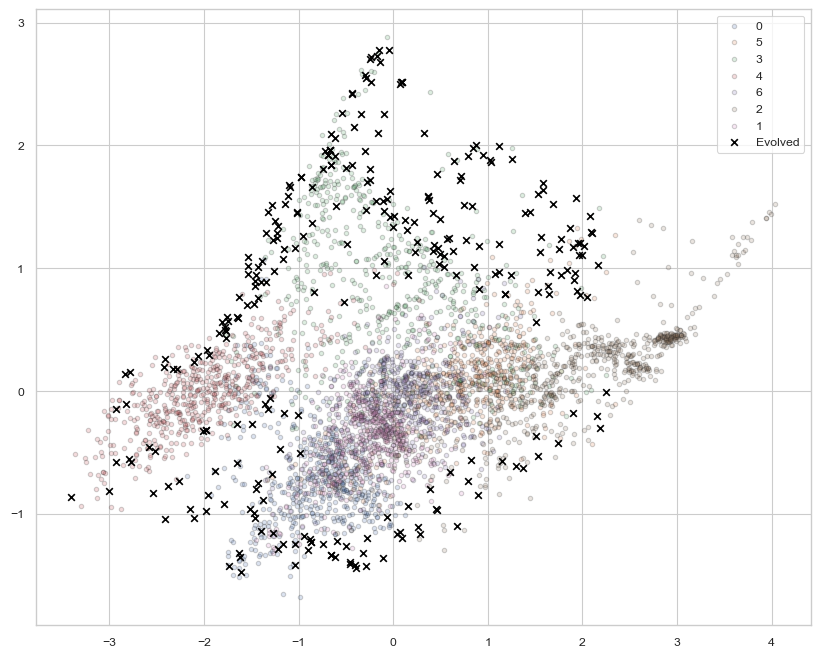

In [24]:
sns.set(style="whitegrid", context="paper")
cmap_bold = ListedColormap([
        '#FF0000',  # Red
        '#00FF00',  # Green
        '#0000FF',  # Blue
        '#FFFF00',  # Yellow
        '#00FFFF',  # Cyan
        '#FF00FF',  # Magenta
        '#FFD700'   # Gold
    ])
# Set dpi
plt.rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 8))
# boundary_points = bounds[['z_1', 'z_2']].values
# plt.gca().add_patch(Polygon(boundary_points, closed=True, fill=False, edgecolor='r', linewidth=2))
# Plot original instances and color by source
for source in original_data['Source'].unique():
    data = original_data[original_data['Source'] == source]
    plt.scatter(data['z_1'], data['z_2'], cmap=cmap_bold, edgecolor='k', s=10, label=source, alpha=.2)
plt.scatter(new_instances['z_1'], new_instances['z_2'], alpha=1, color='black', marker='x', label='Evolved') # New instances

# Add legend
plt.legend()

In [6]:
le = LabelEncoder()
original_data['Source'] = le.fit_transform(original_data['Source'])
original_data['Source'].unique()

array([0, 5, 3, 4, 6, 2, 1])

In [7]:
# Separate features and labels
X = original_data[['z_1', 'z_2']].values
y = original_data['Source'].values

In [8]:
# Function to train model and plot decision surface
def train_and_plot_decision_surface(model_type='SVM', **kwargs):

    # Create color maps
    cmap_light = ListedColormap([
        '#FFBBBB',  # Light red
        '#BBFFBB',  # Light green
        '#BBBBFF',  # Light blue
        '#FFFFBB',  # Light yellow
        '#BBFFFF',  # Light cyan
        '#FFBBFF',  # Light magenta
        '#FFD700'   # Gold
    ])

    cmap_bold = ListedColormap([
        '#FF0000',  # Red
        '#00FF00',  # Green
        '#0000FF',  # Blue
        '#FFFF00',  # Yellow
        '#00FFFF',  # Cyan
        '#FF00FF',  # Magenta
        '#FFD700'   # Gold
    ])

    # Extract data
    X = original_data[['z_1', 'z_2']].values
    y = original_data['Source'].values
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Initialize the model variable
    model = None

    # Configure and train model based on model_type
    if model_type == 'Neural Network':
        # Convert labels to categorical
        y_categorical = to_categorical(y_encoded)

        # Define the neural network structure
        model = Sequential([
            Dense(kwargs.get('hidden_units', 10), activation=kwargs.get('activation', 'relu'), input_shape=(X.shape[1],)),
            Dense(y_categorical.shape[1], activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=kwargs.get('lr', 0.001)),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(X, y_categorical, epochs=kwargs.get('epochs', 100), verbose=0)

    elif model_type == 'SVM':
        model = SVC(kernel=kwargs.get('kernel', 'rbf'), C=kwargs.get('C', 1.0), gamma=kwargs.get('gamma', 'scale'), class_weight=kwargs.get('class_weight', None))

    elif model_type == 'KNN':
        model = KNeighborsClassifier(n_neighbors=kwargs.get('n_neighbors', 5))

    elif model_type == 'Logistic Regression':
        model = LogisticRegression(class_weight=kwargs.get('class_weight', None))

    elif model_type == 'Random Forest':
        model = RandomForestClassifier(class_weight=kwargs.get('class_weight', None))

    else:
        raise ValueError("Invalid model_type. Choose 'SVM', 'KNN', 'Logistic Regression', 'Random Forest', or 'Neural Network'.")

    # Fit the model if not a neural network (NN is already fitted)
    if model_type != 'Neural Network':
        model.fit(X, y_encoded)

    # Generate meshgrid for decision boundary
    x_min, x_max = -12, 10
    y_min, y_max = -10, 10
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict over the meshgrid
    if model_type == 'Neural Network':
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = np.argmax(Z, axis=1).reshape(xx.shape)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    
    # Plot the result
    plt.figure(figsize=(10, 8))
    plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), 
               cmap=cmap_light, aspect='auto', origin='lower')
    # Add evolved instances if provided
    if 'evolved_instances' in kwargs:
        evolved_instances = kwargs['evolved_instances']
        new_instances = plt.scatter(evolved_instances['z_1'], evolved_instances['z_2'], alpha=0.5, color='black', marker='x', label='Evolved') # New instances
    
    if not kwargs.get('hide_original', False):
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)

    # plt.gca().add_patch(Polygon(boundary_points, closed=True, fill=False, edgecolor='r', linewidth=2))

    # Add legend based on source and inverse transform the labels
    handles = [Patch(color=c, label=l) for c, l in zip(cmap_bold.colors, le.classes_)]
    plt.legend(handles=handles)

    #plt.xlim(xx.min(), xx.max())
    # plt.ylim(yy.min(), yy.max())
    plt.xlabel('z_1')
    plt.ylabel('z_2')
    plt.title(f"2D {model_type} Decision Surface")
    plt.show()

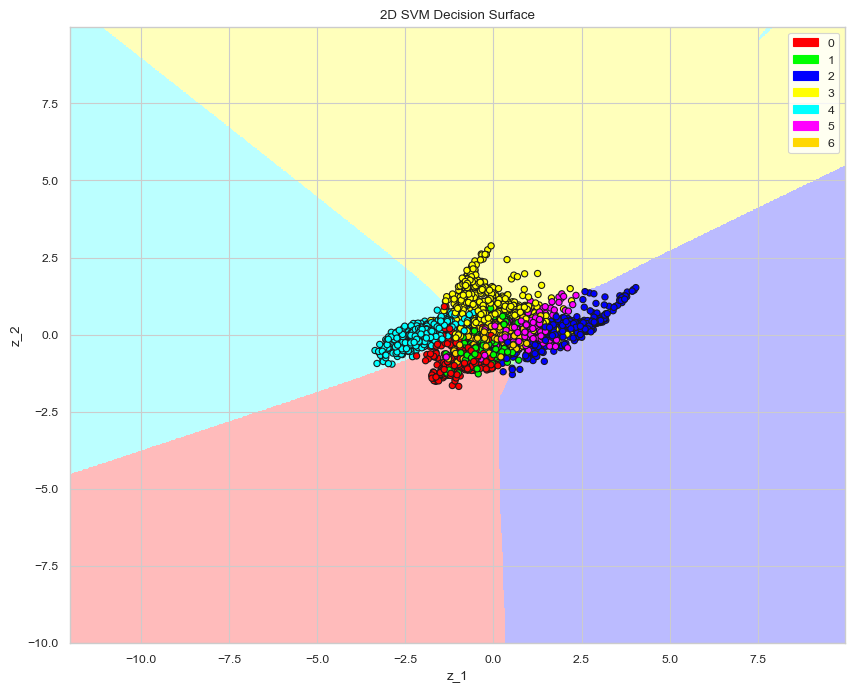

In [9]:
train_and_plot_decision_surface(model_type='SVM', kernel='poly', C=2.0, gamma='scale')

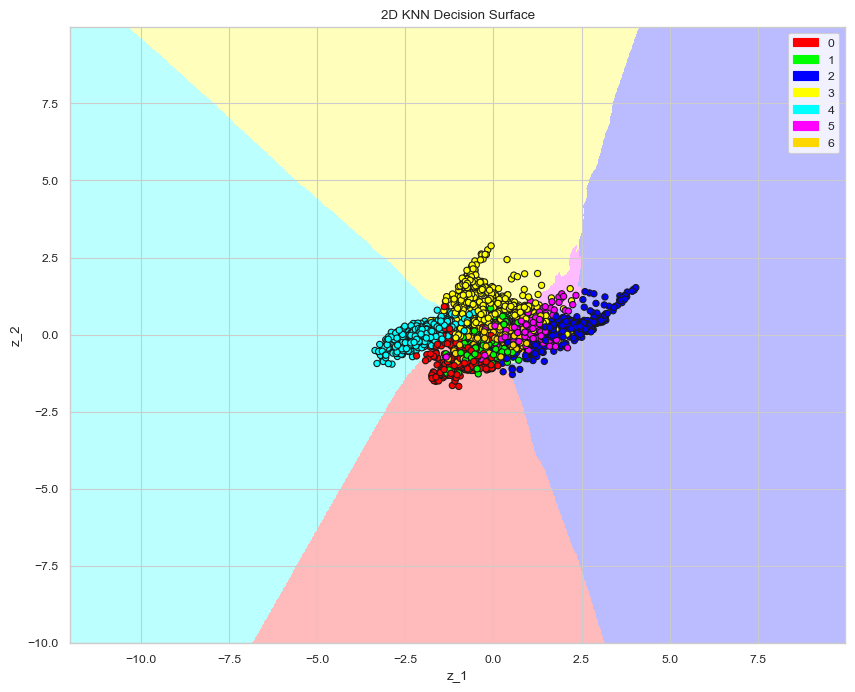

In [10]:
train_and_plot_decision_surface(model_type='KNN', n_neighbors=20)

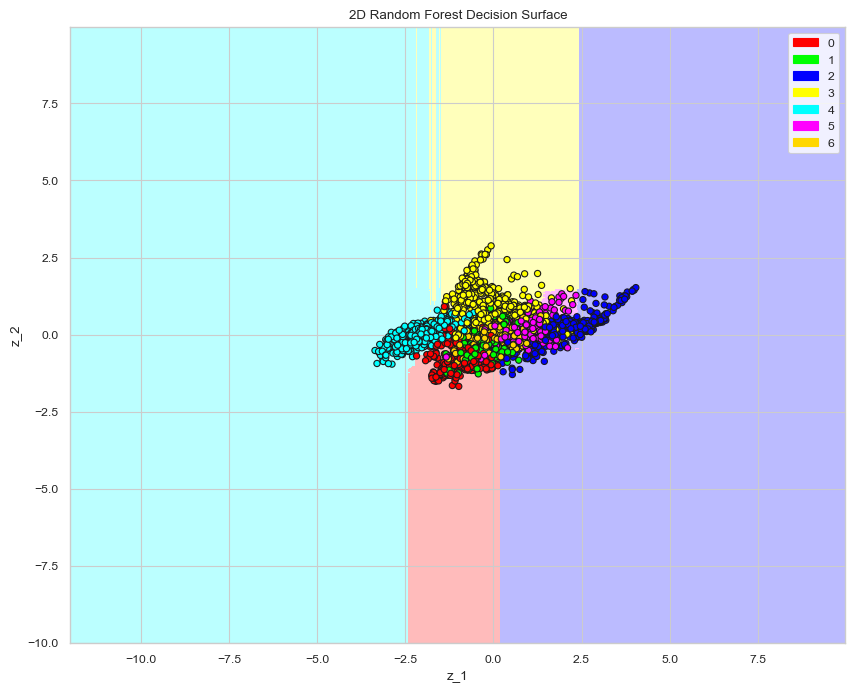

In [11]:
train_and_plot_decision_surface(model_type='Random Forest')

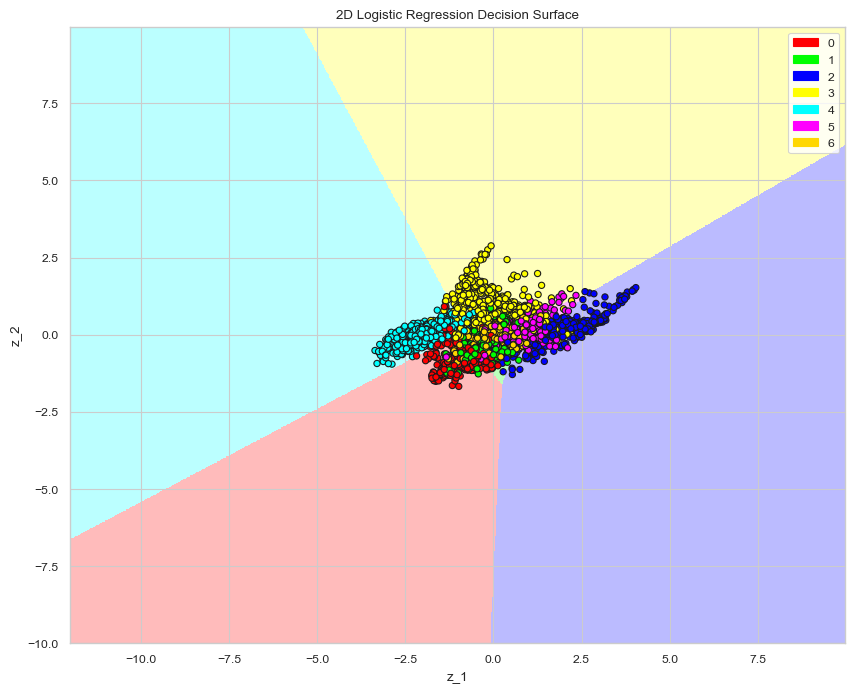

In [12]:
train_and_plot_decision_surface(model_type='Logistic Regression')

/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/instance-generators-4XHX0VJt-py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34375/34375 ━━━━━━━━━━━━━━━━━━━━ 5s 157us/step


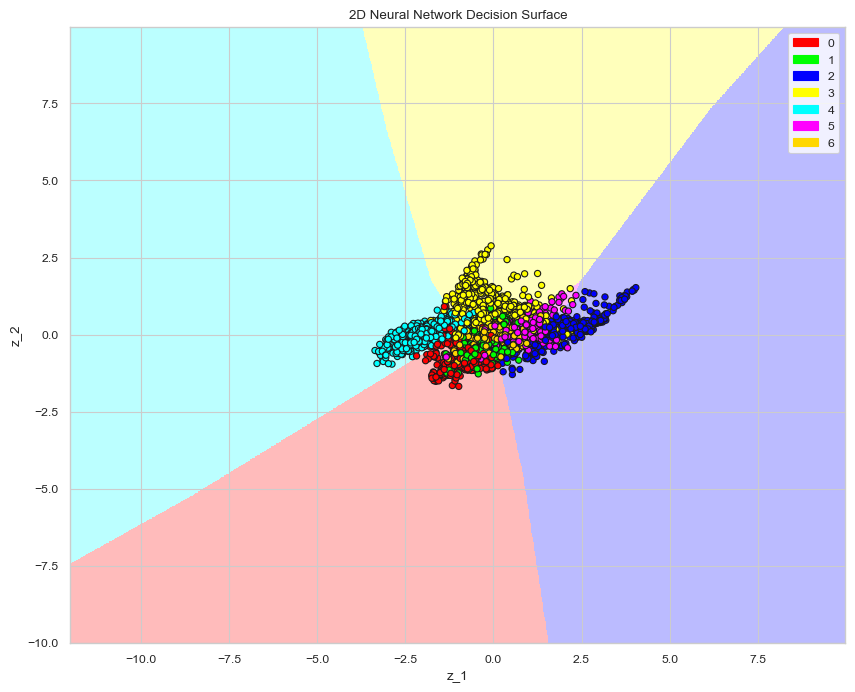

In [13]:
train_and_plot_decision_surface(model_type='Neural Network')

In [14]:
# Split dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# KNN Model
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, Y_train)
knn_predictions = knn.predict(X_test)

# SVM Model
svm = SVC(kernel='poly', C=2, gamma='scale')
svm.fit(X_train, Y_train)
svm_predictions = svm.predict(X_test)

# Random Forest Model
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(X_test)

# Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, Y_train)
lr_predictions = lr.predict(X_test)

# Neural Network Model
y_train_categorical = to_categorical(Y_train)
y_test_categorical = to_categorical(Y_test)
nn = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(y_train_categorical.shape[1], activation='softmax')
])
nn.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train_categorical, epochs=100, verbose=0)
nn_predictions = np.argmax(nn.predict(X_test), axis=1)


# # Get inverse transforms
knn_predictions = le.inverse_transform(knn_predictions)
svm_predictions = le.inverse_transform(svm_predictions)
rf_predictions = le.inverse_transform(rf_predictions)
lr_predictions = le.inverse_transform(lr_predictions)
nn_predictions = le.inverse_transform(nn_predictions)

Y_test = le.inverse_transform(Y_test)

# Evaluation and use source as target_names
knn_report = classification_report(Y_test, knn_predictions)
svm_report = classification_report(Y_test, svm_predictions)
rf_report = classification_report(Y_test, rf_predictions)
lr_report = classification_report(Y_test, lr_predictions)
nn_report = classification_report(Y_test, nn_predictions)


print("KNN Report:\n", knn_report)
print("SVM Report:\n", svm_report)
print("Random Forest Report:\n", rf_report)
print("Logistic Regression Report:\n", lr_report)
print("Neural Network Report:\n", nn_report)

/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/instance-generators-4XHX0VJt-py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
KNN Report:
                             precision    recall  f1-score   support

           3-Regular Graph       0.66      0.82      0.73        51
           4-Regular Graph       0.48      0.58      0.53        50
                 Geometric       0.81      0.86      0.83        56
 Nearly Complete BiPartite       0.86      0.67      0.75        54
            Power Law Tree       0.88      0.93      0.91        57
            Uniform Random       0.65      0.59      0.62        66
Watts-Strogatz small world       0.54      0.44      0.49        61

                  accuracy                           0.69       395
                 macro avg       0.70      0.70      0.69       395
              weighted avg       0.70      0.69      0.69       395

SVM Report:
                             precision    recall  f1-score   support

           3-Regular Graph       0.67      0.69      0.68        51
           4-Regular Graph       0.43      0.1

/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/instance-generators-4XHX0VJt-py3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


<Axes: title={'center': 'Distribution of Evolved Instances'}, ylabel='Source'>

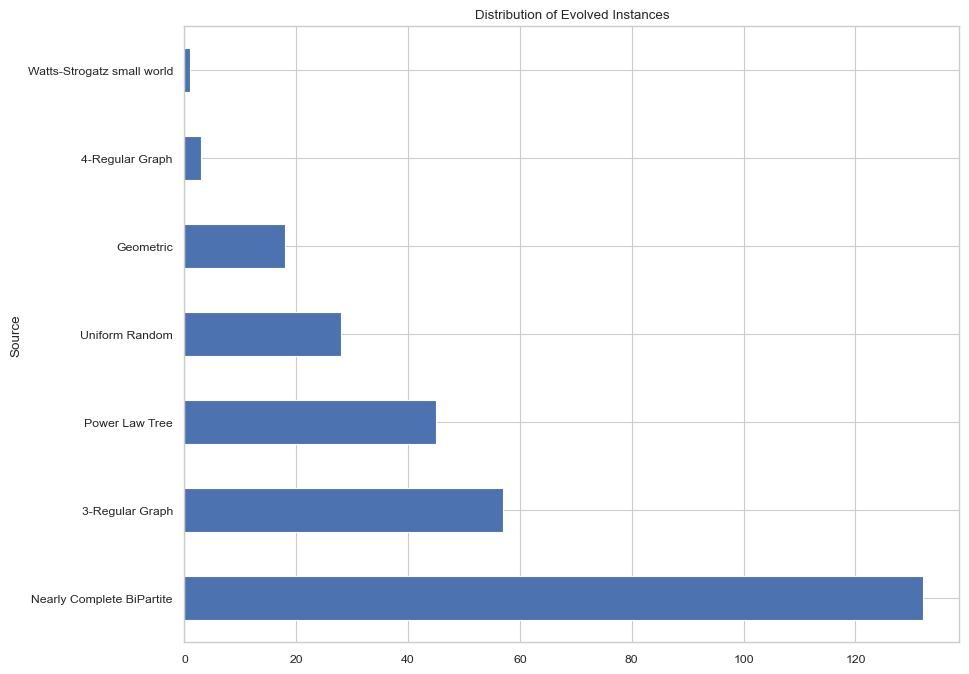

In [15]:
# Now we project the evolved instances into the decision surface
knn_evolved_predictions = knn.predict(new_instances[['z_1', 'z_2']])
# Get inverse transform
knn_evolved_predictions = le.inverse_transform(knn_evolved_predictions)
# Count the number of evolved instances per source
knn_evolved_counts = pd.Series(knn_evolved_predictions).value_counts()

# Plot distribution of evolved instances as a bar plot for each source
plt.figure(figsize=(10, 8))
plt.title('Distribution of Evolved Instances')
plt.ylabel('Source')
knn_evolved_counts.plot(kind='barh')


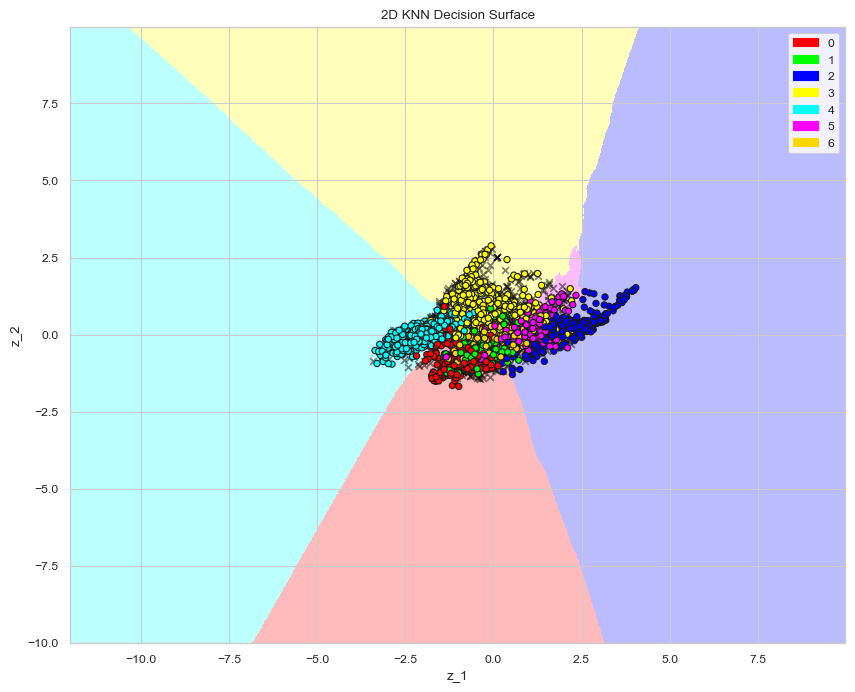

In [16]:
# Now we project the evolved instances into the decision surface
train_and_plot_decision_surface(model_type='KNN', n_neighbors=20, evolved_instances=new_instances)

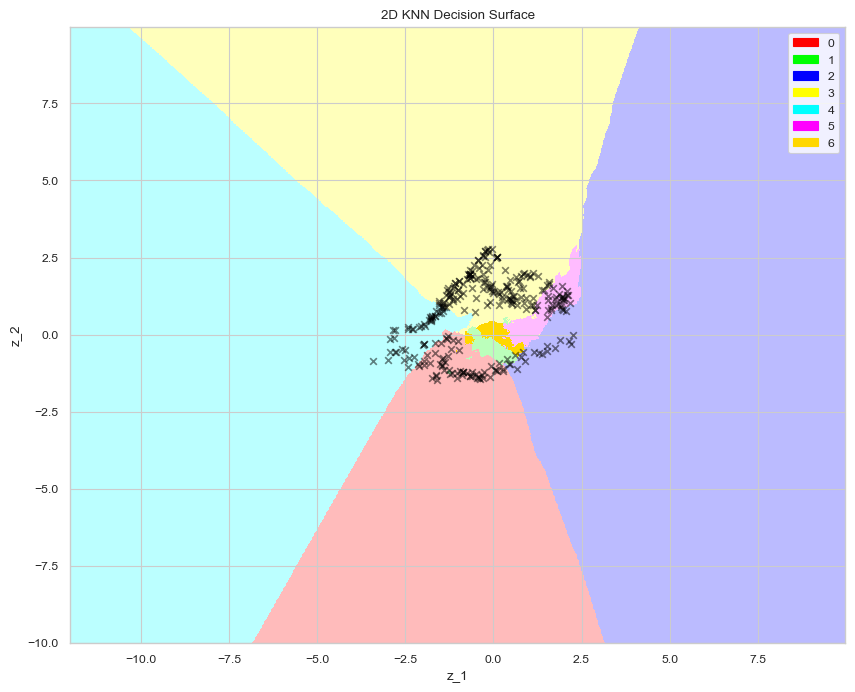

In [17]:
train_and_plot_decision_surface(model_type='KNN', n_neighbors=20, evolved_instances=new_instances, hide_original=True)

In [18]:
# Assign new instances their source
import re
knn_evolved_predictions = np.array([re.sub(r'[\W_]+', '_', s).strip('_').lower() + '_' for s in knn_evolved_predictions])
new_instances['Source_new'] = knn_evolved_predictions + new_instances['Source']
# Function to remove trailing underscore
def remove_trailing_underscore(s):
    if s.endswith('_'):
        return s[:-1]
    return s

# Apply the function to each element in the array
knn_evolved_predictions_cleaned = [remove_trailing_underscore(pred) for pred in knn_evolved_predictions]
new_instances['instance_class'] = knn_evolved_predictions_cleaned

In [19]:
# Save new instances to csv
new_instances.to_csv(f'../{experiment}/final_evolved_instances_n_12_with_source.csv', index=False)

In [20]:
new_instances.instance_class.value_counts()

instance_class
nearly_complete_bipartite     132
3_regular_graph                57
power_law_tree                 45
uniform_random                 28
geometric                      18
4_regular_graph                 3
watts_strogatz_small_world      1
Name: count, dtype: int64

In [21]:
# Which weight distribution to use for the parameters?

In [22]:
knn_evolved_predictions

array(['nearly_complete_bipartite_', 'nearly_complete_bipartite_',
       'power_law_tree_', 'nearly_complete_bipartite_',
       'nearly_complete_bipartite_', 'power_law_tree_',
       'nearly_complete_bipartite_', 'geometric_',
       'nearly_complete_bipartite_', 'uniform_random_', 'power_law_tree_',
       'nearly_complete_bipartite_', '4_regular_graph_',
       'nearly_complete_bipartite_', 'nearly_complete_bipartite_',
       'nearly_complete_bipartite_', 'nearly_complete_bipartite_',
       '3_regular_graph_', '3_regular_graph_', '3_regular_graph_',
       'power_law_tree_', '3_regular_graph_', 'uniform_random_',
       'nearly_complete_bipartite_', 'power_law_tree_',
       'nearly_complete_bipartite_', '4_regular_graph_',
       'nearly_complete_bipartite_', 'power_law_tree_',
       '3_regular_graph_', 'nearly_complete_bipartite_',
       'nearly_complete_bipartite_', 'nearly_complete_bipartite_',
       'nearly_complete_bipartite_', 'power_law_tree_',
       'nearly_complete

In [23]:
new_instances

,z_1,z_2,Source,Source_new,instance_class
0,1.390078,1.447221,target_point_1.3447058823529414_1.285294117647...,nearly_complete_bipartite_target_point_1.34470...,nearly_complete_bipartite
1,1.033745,1.863531,target_point_0.631578947368421_2.6789473684210...,nearly_complete_bipartite_target_point_0.63157...,nearly_complete_bipartite
2,-1.460238,0.859186,target_point_-1.6666666666666667_0.83333333333...,power_law_tree_target_point_-1.666666666666666...,power_law_tree
3,-0.153573,2.779136,target_point_0.8421052631578947_2.605263157894...,nearly_complete_bipartite_target_point_0.84210...,nearly_complete_bipartite
4,0.089295,2.514753,target_point_1.102941176470588_2.0658823529411...,nearly_complete_bipartite_target_point_1.10294...,nearly_complete_bipartite
...,...,...,...,...,...
279,-0.032185,1.630777,target_point_0.3441176470588235_2.145058823529...,nearly_complete_bipartite_target_point_0.34411...,nearly_complete_bipartite
280,-2.144231,-0.961832,target_point_-1.7999999999999998_-0.9071428571...,3_regular_graph_target_point_-1.79999999999999...,3_regular_graph
281,1.634686,0.857115,target_point_1.8205882352941174_0.794117647058...,uniform_random_target_point_1.8205882352941174...,uniform_random
282,-1.780164,0.523360,target_point_-2.0588235294117645_0.94117647058...,power_law_tree_target_point_-2.058823529411764...,power_law_tree
